## First model

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer

from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Config
from transformers import get_linear_schedule_with_warmup

import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
import os
from pathlib import Path

Load our data

In [2]:
data_path = Path(os.getcwd()).parent / 'data'

df = pd.read_csv(f'{data_path}/lyrics_filtered_768tokens.csv')


print(f"Loaded {len(df):,} songs")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst row preview:")
print(df.iloc[0])

Loaded 39,415 songs

Columns: ['genre', 'lyrics', 'token_count', 'formatted_text']

First row preview:
genre                                                           Pop
lyrics            I feel so unsure\nAs I take your hand and lead...
token_count                                                     400
formatted_text    Genre: Pop\n\nI feel so unsure\nAs I take your...
Name: 0, dtype: object


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
model_name = 'gpt2'
model_save_path = Path(os.getcwd()).parent / 'models'


In [4]:
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print(f"\nTokenizer loaded:")
print(f"Vocab size: {len(tokenizer):,}")
print(f"EOS token: '{tokenizer.eos_token}' (ID: {tokenizer.eos_token_id})")
print(f"PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]


Tokenizer loaded:
Vocab size: 50,257
EOS token: '<|endoftext|>' (ID: 50256)
PAD token: '<|endoftext|>' (ID: 50256)


### Custom dataset

In [5]:
from torch.utils.data import Dataset
import torch
from tqdm import tqdm

class LyricsDataset(Dataset):
    
    def __init__(self, formatted_texts, tokenizer, max_length=768):

        self.input_ids = []
        self.attn_masks = []
        
        print(f"Pre-tokenizing {len(formatted_texts)} songs...")
        for text in tqdm(formatted_texts):
            encodings = tokenizer.encode_plus(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt'
            )
            self.input_ids.append(encodings['input_ids'].squeeze(0))
            self.attn_masks.append(encodings['attention_mask'].squeeze(0))
        
        print("Tokenization complete")
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attn_masks[idx],
            'labels': self.input_ids[idx]  # Same as input for LM
        }


init the loader

In [12]:


train_df, temp_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['genre'],
    random_state=6
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['genre'],
    random_state=6
)

train_dataset = LyricsDataset(train_df['formatted_text'].tolist(), tokenizer, 768)
val_dataset = LyricsDataset(val_df['formatted_text'].tolist(), tokenizer, 768)
test_dataset = LyricsDataset(test_df['formatted_text'].tolist(), tokenizer, 768)

Pre-tokenizing 31532 songs...


  0%|          | 0/31532 [00:00<?, ?it/s]

100%|██████████| 31532/31532 [00:59<00:00, 525.99it/s]


Tokenization complete
Pre-tokenizing 3941 songs...


100%|██████████| 3941/3941 [00:07<00:00, 542.85it/s]


Tokenization complete
Pre-tokenizing 3942 songs...


100%|██████████| 3942/3942 [00:07<00:00, 541.79it/s]

Tokenization complete


In [14]:
print(f"Dataset size: {len(train_dataset)}")
sample = train_dataset[0]
print(f"Sample shapes:")
print(f"  input_ids: {sample['input_ids'].shape}")
print(f"  attention_mask: {sample['attention_mask'].shape}")

Dataset size: 31532
Sample shapes:
  input_ids: torch.Size([768])
  attention_mask: torch.Size([768])


Create data loaders

In [32]:
from torch.utils.data import DataLoader
BATCH_SIZE = 2
MAX_LENGTH = 512

In [33]:


train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,       # Don't shuffle validation
    num_workers=0,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 15766
Val batches: 1971
Test batches: 1971


In [7]:
small_ete_test = df[0:10]
small_train_df, small_val_df = train_test_split(
    small_ete_test, 
    test_size=0.2, 
    stratify=small_ete_test['genre'],
    random_state=6
)
small_train_dataset = LyricsDataset(small_train_df['formatted_text'].tolist(), tokenizer, 768)
small_val_dataset = LyricsDataset(small_val_df['formatted_text'].tolist(), tokenizer, 768)

small_train_loader = DataLoader(
    small_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

small_val_loader = DataLoader(
    small_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

Pre-tokenizing 8 songs...


100%|██████████| 8/8 [00:00<00:00, 308.57it/s]


Tokenization complete
Pre-tokenizing 2 songs...


100%|██████████| 2/2 [00:00<00:00, 377.10it/s]

Tokenization complete


### Train the model

In [35]:
from tqdm.notebook import tqdm
def train_loop(model, optimizer, scheduler, train_loader, device, epoch, num_epochs):
    epoch_train_loss = 0
    print(f"Starting training epoch {epoch+1}/{num_epochs} with {len(train_loader)} batches")
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Training)")
    for batch in progress_bar:
            try:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=input_ids
                )
                loss = outputs.loss
                epoch_train_loss += loss.item()

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step()
                progress_bar.set_postfix({'train_loss': loss.item()})
                progress_bar.refresh()
            
            except RuntimeError as e:
                print(f"Error in training batch: {e}")
                raise
    return epoch_train_loss

def train_gpt2_model(
    model,
    train_loader,
    val_loader,
    device,
    optimizer,
    scheduler,
    num_epochs=3,
    patience=2,
    model_name="last_training"
    ):
    os.makedirs("./models", exist_ok=True)
    model = model.to(device)
    model.train()
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):

        model.train()


        epoch_train_loss = train_loop(model, optimizer, scheduler, train_loader, device, epoch, num_epochs)
        
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs} - Avg Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)"):
                try:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)

                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=input_ids
                    )
                    epoch_val_loss += outputs.loss.item()
                
                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    raise

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}: Avg Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss - 0.01:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f"./models/{model_name}.pt")
            print(f'Saved best model checkpoint: epoch {epoch + 1}')
        else:
            patience_counter += 1
            print(f"Patience counter: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print(f"Early stopping triggered after epoch {epoch + 1}")
                break

    return model, train_losses, val_losses
    

In [ ]:
from transformers import get_linear_schedule_with_warmup

LEARNING_RATE = 5e-5
NUM_EPOCHS = 3
WARMUP_STEPS = 500

model = GPT2LMHeadModel.from_pretrained(model_name)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(small_train_loader) * NUM_EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

### Test with small dataset

In [10]:
model, train_losses, val_losses = train_gpt2_model(model, small_train_loader, small_val_loader, 'cpu', optimizer, scheduler, num_epochs=2)

Epoch 1/2 (Training):   0%|          | 0/8 [00:39<?, ?it/s, train_loss=7.66]


Epoch 1/2 - Avg Training Loss: 7.8783


Epoch 1/2 (Validation): 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


Epoch 1/2: Avg Validation Loss: 9.8655
Saved best model checkpoint: epoch 1


Epoch 2/2 (Training):   0%|          | 0/8 [00:36<?, ?it/s, train_loss=7.53]


Epoch 2/2 - Avg Training Loss: 7.5802


Epoch 2/2 (Validation): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


Epoch 2/2: Avg Validation Loss: 9.4303
Saved best model checkpoint: epoch 2


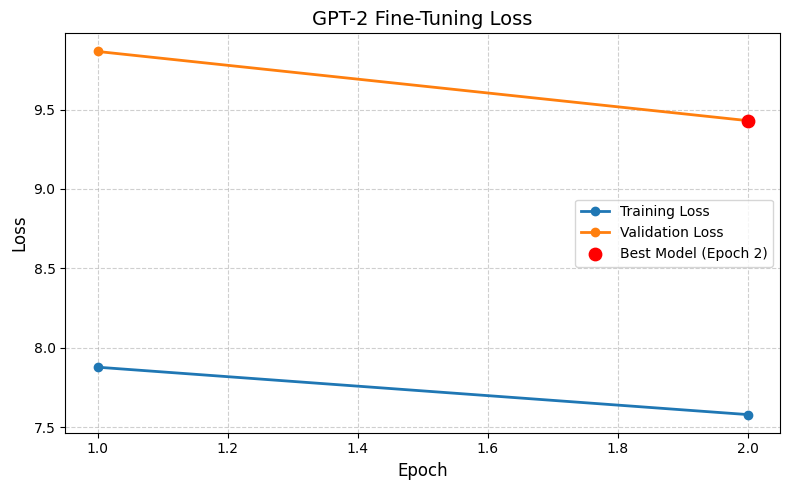

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def plot_training_curves(train_losses, val_losses, title="GPT-2 Fine-Tuning Loss"):
    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, 'o-', label="Training Loss", linewidth=2)
    plt.plot(epochs, val_losses, 'o-', label="Validation Loss", linewidth=2)

    best_epoch = np.argmin(val_losses) + 1
    plt.scatter(best_epoch, val_losses[best_epoch-1], color='red', s=80, zorder=5, label=f"Best Model (Epoch {best_epoch})")

    plt.title(title, fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, val_losses)

 ### Big TF

In [36]:
from transformers import get_linear_schedule_with_warmup

LEARNING_RATE = 3e-5
NUM_EPOCHS = 3
WARMUP_RATIO = 0.05

model = GPT2LMHeadModel.from_pretrained(model_name)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

total_steps = len(train_loader) * NUM_EPOCHS
warmup_steps = int(total_steps * WARMUP_RATIO)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
print('Using:', device)
model2, train_losses_b, val_losses_b = train_gpt2_model(model, train_loader, val_loader, device, optimizer, scheduler, num_epochs=NUM_EPOCHS, model_name='gpt2_all_data_model')

Using: cuda
Starting training epoch 1/3 with 15766 batches


Epoch 1/3 (Training):   0%|          | 0/15766 [00:00<?, ?it/s]

Epoch 1/2 (Training):   0%|          | 0/31532 [28:22<?, ?it/s, train_loss=0.794]


KeyboardInterrupt: 

In [ ]:
plot_training_curves(train_losses_b, val_losses_b)